<a href="https://colab.research.google.com/github/RodMendez/entropyGalxiesML/blob/main/MC_DropOut_2_(Mayor_R).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install getdist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.6/826.6 kB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.5.4-py3-none-any.whl size=810910 sha256=80eecd5eba6745f36889c689cee872b78c84185b4d2e5d93cba23838309643e3
  Stored in directory: /root/.cache/pip/wheels/ed/1f/4b/8b586319345aee601e2c6efaf3038891e4e900d68af4eff79f
Successfully built getdist


In [2]:
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
from getdist import *
# import planckStyle
import pylab
import numpy as np
# import tkinter
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker

In [3]:
!pip install fgivenx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.3/617.3 kB 20.2 MB/s eta 0:00:00


In [4]:
!pip install astroNN


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.9/912.9 kB 26.5 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg
from scipy.misc import derivative
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

In [6]:
df_data = pd.read_csv("Mayor R  (R500).csv")

In [20]:
print(df_data.columns)

Index(['Nombre', 'Rmax rayos X', 'nelec', 'Tx', 'S', 'σLOS', 'Rvir', 'Mvir',
       'A', 'Hz', 'R500', 'CC'],
      dtype='object')


In [7]:
from sklearn.preprocessing import StandardScaler

# Para la variable de entrada principal
X_rmax = df_data[['Rmax rayos X']].values
scaler_rmax = StandardScaler()
X_rmax_scaled = scaler_rmax.fit_transform(X_rmax)

# Para las variables auxiliares de entrada
aux_columns = ['nelec', 'Tx', 'σLOS', 'Rvir', 'Mvir']
X_aux = df_data[aux_columns].values
scaler_aux = StandardScaler()
X_aux_scaled = scaler_aux.fit_transform(X_aux)

# Para las variables de salida (por separado)
scaler_Hz = StandardScaler()
scaler_S = StandardScaler()

Hz_scaled = scaler_Hz.fit_transform(df_data[['Hz']].values)
S_scaled = scaler_S.fit_transform(df_data[['S']].values)

# Si necesitas las salidas juntas en un array
y_scaled = np.hstack([Hz_scaled, S_scaled])

# Combina todas las variables de entrada si es necesario
X_scaled = np.hstack([X_rmax_scaled, X_aux_scaled])

# Valores mínimos y máximos de Rmax escalado (
xmin, xmax = np.min(X_rmax_scaled), np.max(X_rmax_scaled)

In [8]:
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

def get_smoothed_curve(rmax_scaled, prediction, sigma, curve_type='lower', frac=0.05):
    """
    Obtener la curva suavizada basada en las predicciones y el tipo de curva.

    Parámetros:
    - rmax_scaled: Variable de entrada 'Rmax rayos X' escalada.
    - prediction: Valores predichos centrales (media de las predicciones), escalados si es necesario.
    - sigma: Desviación estándar de las predicciones (incertidumbre).
    - curve_type: String, 'upper' o 'lower'. Especifica si devolver la curva superior o inferior.
    - frac: Fracción para el suavizado LOWESS.

    Retorna:
    - smoothed_curve: Array con dos columnas: la primera con los valores x y la segunda con los valores y de la curva suavizada.
    """
    # Determinar el tipo de curva (superior o inferior)
    if curve_type == 'lower':
        prediction_curve = prediction - sigma
    elif curve_type == 'upper':
        prediction_curve = prediction + sigma
    else:
        raise ValueError("curve_type debe ser 'upper' o 'lower'")

    # Interpolación
    f = interp1d(rmax_scaled.flatten(), prediction_curve, fill_value="extrapolate")

    # Nuevo rango de valores escalados X para la interpolación
    new_X = np.linspace(min(rmax_scaled.flatten()), max(rmax_scaled.flatten()), 100)

    # Valores interpolados
    interpolated_values = f(new_X)

    # Suavizado de la curva usando LOWESS
    smoothed_curve = lowess(interpolated_values, new_X.ravel(), frac=frac)

    return smoothed_curve


In [9]:
from keras.metrics import MeanSquaredError

#Carga el modelo desde la ubicación actual
model = tf.keras.models.load_model('large_lsst_model.h5', custom_objects={'MCDropout': MCDropout,'mse': MeanSquaredError()})

#¿El modelo fue entrenado con esa métrica?

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
rmax_scaled = X_scaled[:, 0].reshape(-1, 1)

#Parámetros
test_batch_size = rmax_scaled.shape[0]  # Usa el tamaño del conjunto de datos escalado

mc_dropout_num = 100  # Ejecuta Dropout 100 veces

#Inicializa matrices para almacenar predicciones y varianza
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))  # 2 es el número de salidas: Hz y S

#Ejecuta Monte Carlo Dropout
for j in range(mc_dropout_num):

    predictions[j] = model.predict(rmax_scaled)  # Usa solo Rmax rayos X

#Obtiene los resultados promedio y su varianza
prediction_mc_dropout = np.mean(predictions, axis=0)

std_mc_dropout = np.std(predictions, axis=0)

#Genera las curvas suavizadas superior e inferior
smoothed_lower_curve = get_smoothed_curve(rmax_scaled, prediction_mc_dropout[:, 0], std_mc_dropout[:, 0], curve_type='lower')

smoothed_upper_curve = get_smoothed_curve(rmax_scaled, prediction_mc_dropout[:, 0], std_mc_dropout[:, 0], curve_type='upper')

#Imprimir resultados
print("Predicciones promedio (Hz):")

print(prediction_mc_dropout[:, 0])

print("Desviación estándar (incertidumbre, Hz):")

print(std_mc_dropout[:, 0])

print("Curva suavizada inferior:")

print(smoothed_lower_curve)

print("Curva suavizada superior:")

print(smoothed_upper_curve)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━

In [23]:
print(len(prediction_mc_dropout[:, 0]), len(rmax_scaled))


38 38


In [14]:
# Desescalamos los resultados
# Para Hz
hz_means_unscaled = scaler_Hz.inverse_transform(prediction_mc_dropout[:, 0].reshape(-1, 1))
hz_stds_unscaled = std_mc_dropout[:, 0] * scaler_Hz.scale_

# Para S
s_means_unscaled = scaler_S.inverse_transform(prediction_mc_dropout[:, 1].reshape(-1, 1))
s_stds_unscaled = std_mc_dropout[:, 1] * scaler_S.scale_

# Desescalamos Rmax
rmax_unscaled = scaler_rmax.inverse_transform(X_scaled)

print("Predicciones desescaladas para cada punto de Rmax:")
print("\nFormato: Valor ± Incertidumbre")
print("\nHz predictions:")
for i in range(len(rmax_unscaled)):
    print(f"Rmax = {rmax_unscaled[i][0]:.2f}: Hz = {hz_means_unscaled[i][0]:.2f} ± {hz_stds_unscaled[i]:.2f}")

print("\nS predictions:")
for i in range(len(rmax_unscaled)):
    print(f"Rmax = {rmax_unscaled[i][0]:.2f}: S = {s_means_unscaled[i][0]:.2f} ± {s_stds_unscaled[i]:.2f}")

Predicciones desescaladas para cada punto de Rmax:

Formato: Valor ± Incertidumbre

Hz predictions:
Rmax = 0.25: Hz = 44.55 ± 0.80
Rmax = 0.49: Hz = 44.75 ± 0.86
Rmax = 0.14: Hz = 44.41 ± 0.77
Rmax = 0.50: Hz = 44.83 ± 0.80
Rmax = 0.50: Hz = 44.87 ± 0.79
Rmax = 0.24: Hz = 44.42 ± 0.73
Rmax = 0.12: Hz = 44.25 ± 0.80
Rmax = 0.08: Hz = 44.34 ± 0.67
Rmax = 0.31: Hz = 44.75 ± 0.77
Rmax = 0.18: Hz = 44.50 ± 0.77
Rmax = 0.34: Hz = 44.68 ± 0.70
Rmax = 0.06: Hz = 44.26 ± 0.75
Rmax = 0.29: Hz = 44.70 ± 0.81
Rmax = 0.28: Hz = 44.57 ± 0.77
Rmax = 0.30: Hz = 44.67 ± 0.75
Rmax = 0.27: Hz = 44.72 ± 0.84
Rmax = 0.38: Hz = 44.82 ± 0.75
Rmax = 0.50: Hz = 44.91 ± 0.69
Rmax = 0.12: Hz = 44.36 ± 0.75
Rmax = 0.29: Hz = 44.65 ± 0.77
Rmax = 0.54: Hz = 44.96 ± 0.83
Rmax = 0.40: Hz = 44.77 ± 0.91
Rmax = 0.20: Hz = 44.47 ± 0.86
Rmax = 0.08: Hz = 44.23 ± 0.84
Rmax = 0.10: Hz = 44.26 ± 0.70
Rmax = 1.05: Hz = 45.32 ± 0.96
Rmax = 0.32: Hz = 44.72 ± 0.68
Rmax = 0.73: Hz = 45.08 ± 0.80
Rmax = 0.25: Hz = 44.61 ± 0.89
R

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Recuperar los valores originales de y
y_Hz = df_data[['Hz']].values
y_S = df_data[['S']].values


# Evaluar rendimiento para Hz
mse_Hz = mean_squared_error(y_Hz, hz_means_unscaled.flatten())
mae_Hz = mean_absolute_error(y_Hz, hz_means_unscaled.flatten())
r2_Hz = r2_score(y_Hz, hz_means_unscaled.flatten())

print("Rendimiento del modelo para Hz:")
print(f"Mean Squared Error (MSE): {mse_Hz:.4f}")
print(f"Mean Absolute Error (MAE): {mae_Hz:.4f}")
print(f"R² Score: {r2_Hz:.4f}")

# Evaluar rendimiento para S
mse_S = mean_squared_error(y_S, s_means_unscaled.flatten())
mae_S = mean_absolute_error(y_S, s_means_unscaled.flatten())
r2_S = r2_score(y_S, s_means_unscaled.flatten())

print("\nRendimiento del modelo para S:")
print(f"Mean Squared Error (MSE): {mse_S:.4f}")
print(f"Mean Absolute Error (MAE): {mae_S:.4f}")
print(f"R² Score: {r2_S:.4f}")

Rendimiento del modelo para Hz:
Mean Squared Error (MSE): 845.3328
Mean Absolute Error (MAE): 29.0639
R² Score: -1847.2555

Rendimiento del modelo para S:
Mean Squared Error (MSE): 67544.4791
Mean Absolute Error (MAE): 214.1181
R² Score: -0.0128


In [24]:
# Verificar tamaños
print("Tamaño de rmax_unscaled:", rmax_unscaled.shape)
print("Tamaño de y_Hz:", y_Hz.shape)
print("Tamaño de hz_means_unscaled:", hz_means_unscaled.shape)
print("Tamaño de sigma_Hz:", sigma_Hz.shape)


Tamaño de rmax_unscaled: (228,)
Tamaño de y_Hz: (38,)
Tamaño de hz_means_unscaled: (38,)
Tamaño de sigma_Hz: (38,)


In [29]:
# Asumiendo que el modelo se entrenó y evaluó con un subconjunto específico de los datos,
# usa esos mismos índices para filtrar rmax_unscaled.
indices = np.arange(len(prediction_mc_dropout))  # Esto genera un array de índices [0, 1, ..., 37]

# Filtra rmax_unscaled para que coincida con las predicciones
rmax_filtered = rmax_unscaled[indices]  # Esto tomará solo los primeros 38 valores


In [32]:
print(len(rmax_filtered), len(hz_means_unscaled), len(hz_stds_unscaled))


38 38 38


In [34]:
import matplotlib.pyplot as plt

# Calcula la incertidumbre combinada (ajusta según sea necesario)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2)

# Crea la figura
plt.figure(figsize=(10, 7), dpi=100)

# Suponiendo que `rmax_unscaled` tiene los valores de entrada
plt.errorbar(rmax_filtered.flatten(), hz_means_unscaled.flatten(), yerr=hz_stds_unscaled.flatten(),
             fmt='o', ecolor='m', capthick=2, elinewidth=0.8, alpha=0.05, c='m',
             label='Reconstrucción Neural con $\sigma$')

# Aquí, puedes plotear el modelo o la línea de referencia si lo tienes
# Por ejemplo, si tienes una línea de referencia de un modelo:
# plt.plot(rmax_unscaled, model_reference, label='Modelo de Referencia', c='b', linewidth=2)

plt.xlim(np.min(rmax_unscaled) - 0.01, np.max(rmax_unscaled) + 0.01)
plt.ylim(np.min(hz_means_unscaled) - 1, np.max(hz_means_unscaled) + 1)

# Etiquetas de los ejes
plt.xlabel("Rmax (unscaled)", fontsize=20)
plt.ylabel("$H(z)$", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Leyenda
plt.legend(fontsize=12, loc='lower center')

# Ajusta el layout y guarda la figura
plt.tight_layout()
plt.savefig('neural_rec_large.png', dpi=100)
plt.show()


In [36]:
print(rmax_filtered)
print(hz_means_unscaled)
print(hz_stds_unscaled)

[ 0.251       0.2931159   0.03150197  1.10335266  1.3653509   1.58590798
  0.491       0.27117891  0.61648802  0.48968258  0.51569138  0.3729658
  0.138       0.32034804  0.27134625  0.24996771  0.25035402  0.12220787
  0.503       0.21932439  0.72178551  0.79971382  0.6998326   0.62145442
  0.502       0.22526251  2.01167976  1.04262489  0.99126872  1.0083705
  0.243       0.27117891 -0.47451097 -1.14037855 -1.24162491 -0.62893125
  0.116       0.67285287]
[44.55380122 44.74812111 44.40832048 44.83277764 44.86621545 44.41834393
 44.24963541 44.34006903 44.75055047 44.49967626 44.67977635 44.2577405
 44.69525581 44.56825199 44.66654205 44.72032294 44.82312315 44.90540341
 44.36261656 44.65304334 44.96179272 44.77367431 44.46560229 44.22878875
 44.26017115 45.31770552 44.71679235 45.08429872 44.60667779 44.95222056
 44.85592028 44.8521605  44.45368229 44.45190258 44.35830219 44.51639136
 46.89577946 44.72799941]
[0.80340514 0.85663449 0.76917295 0.80087555 0.79386819 0.73341835
 0.80248

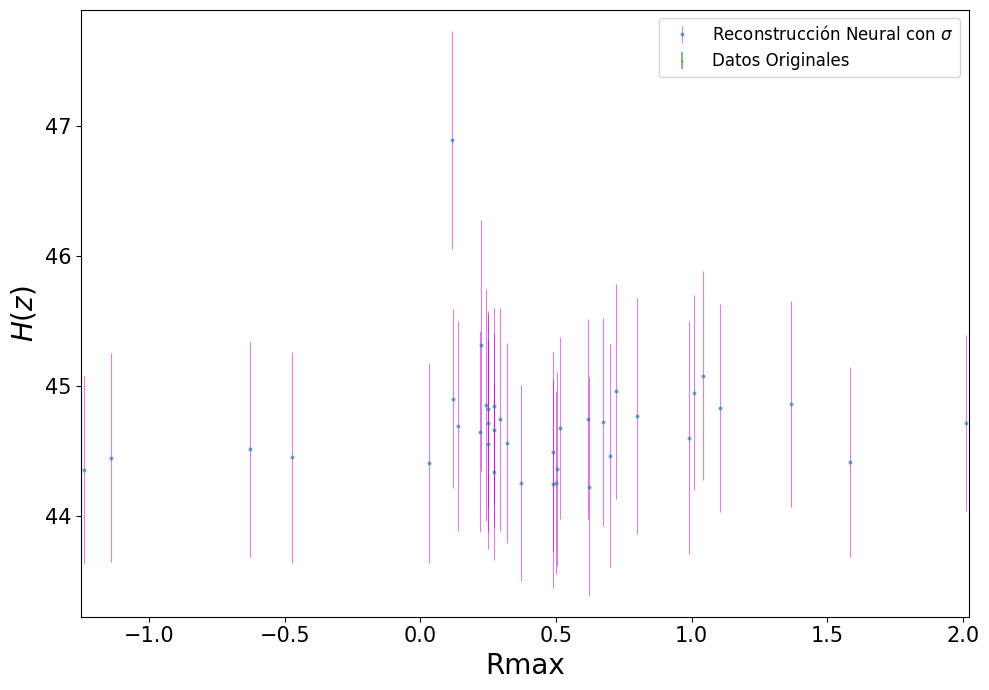

In [43]:

# Supongamos que rmax_unscaled, hz_means_unscaled y hz_stds_unscaled ya están definidos

# Calcula sigma (incertidumbre total)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2 + prediction_mc_dropout[:, 1]**2)

plt.figure(figsize=(10, 7), dpi=100)

# Gráfico de las predicciones de Hz con incertidumbre
plt.errorbar(rmax_filtered.flatten(), hz_means_unscaled.flatten(),
             yerr=hz_stds_unscaled.flatten(), markersize=2, fmt='o',
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.5,
             label='Reconstrucción Neural con $\sigma$')

# Opcionalmente, si deseas agregar los valores originales de Hz
plt.errorbar(rmax_filtered.flatten(), y_Hz.flatten(), yerr=0.1 * y_Hz.flatten(),
             fmt='g.', markersize=1, alpha=0.5, label='Datos Originales')

plt.xlim(np.min(rmax_filtered)-0.01, np.max(rmax_filtered)+0.01)
plt.ylim(np.min(hz_means_unscaled)-1, np.max(hz_means_unscaled)+1)

plt.xlabel("Rmax", fontsize=20)
plt.ylabel("$H(z)$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, loc='best')

plt.tight_layout()
plt.savefig('neural_rec_large.png', dpi=100)
plt.show()



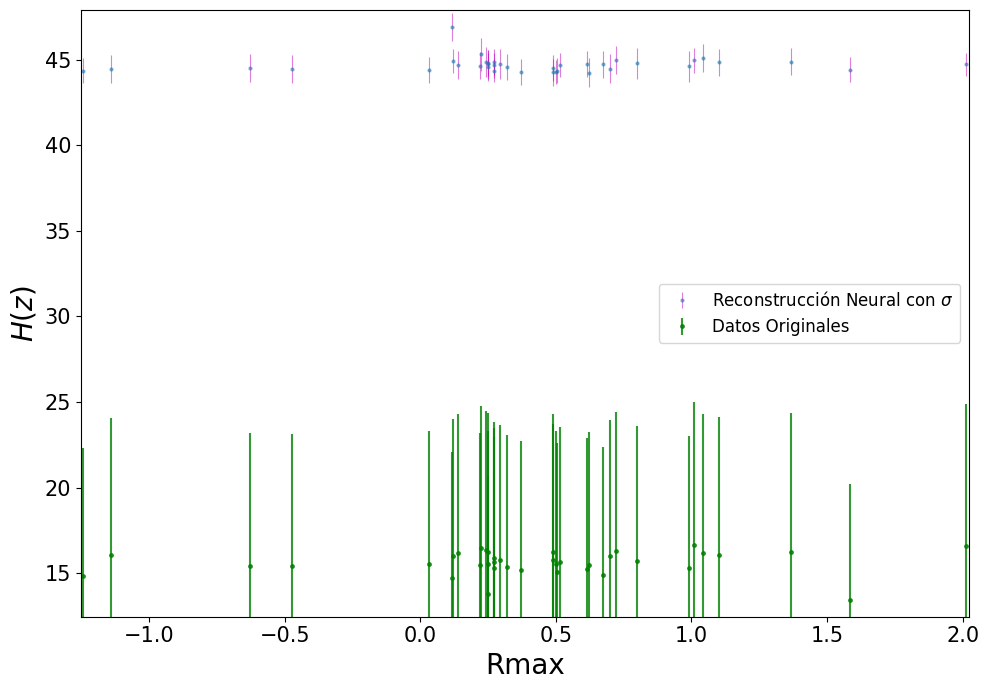

In [45]:
# Supongamos que rmax_filtered, hz_means_unscaled y hz_stds_unscaled ya están definidos

# Calcula sigma (incertidumbre total)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2 + prediction_mc_dropout[:, 1]**2)

plt.figure(figsize=(10, 7), dpi=100)

# Gráfico de las predicciones de Hz con incertidumbre
plt.errorbar(rmax_filtered.flatten(), hz_means_unscaled.flatten(),
             yerr=hz_stds_unscaled.flatten(), markersize=2, fmt='o',
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.5,
             label='Reconstrucción Neural con $\sigma$')

# Agregar los valores originales de Hz
plt.errorbar(rmax_filtered.flatten(), y_Hz.flatten(), yerr=0.5 * y_Hz.flatten(),
             fmt='g.', markersize=5, alpha=0.8, label='Datos Originales')  # Aumenté el tamaño y error

# Ajustar los límites del eje Y
plt.xlim(np.min(rmax_filtered)-0.01, np.max(rmax_filtered)+0.01)
plt.ylim(min(np.min(hz_means_unscaled), np.min(y_Hz)) - 1, max(np.max(hz_means_unscaled), np.max(y_Hz)) + 1)

plt.xlabel("Rmax", fontsize=20)
plt.ylabel("$H(z)$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, loc='best')

plt.tight_layout()
plt.savefig('neural_rec_large.png', dpi=100)
plt.show()


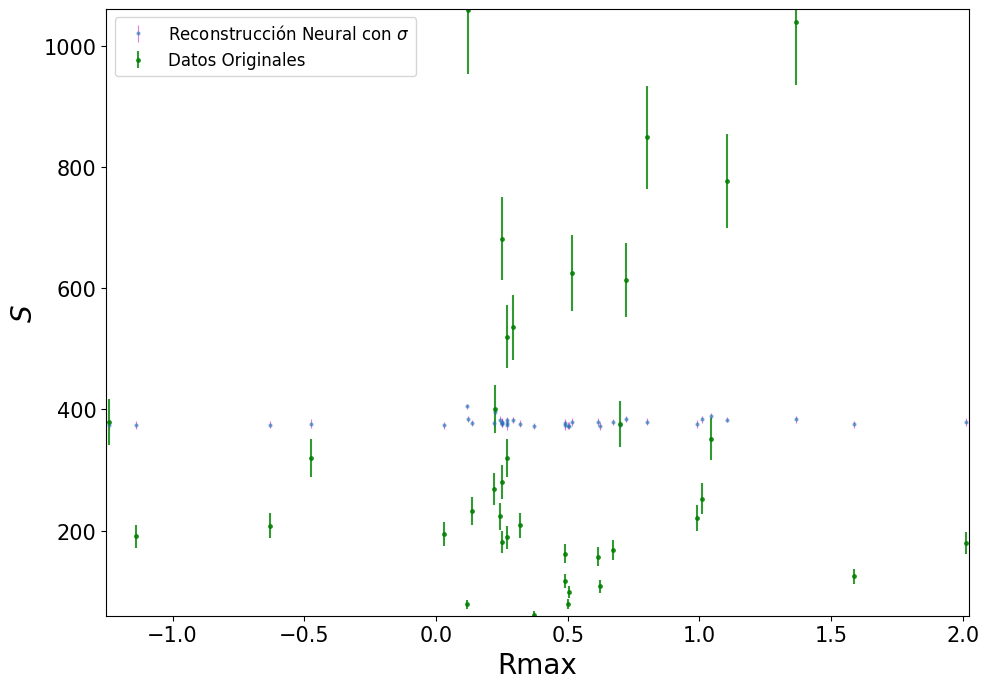

In [46]:
# Supongamos que rmax_filtered, s_means_unscaled y s_stds_unscaled ya están definidos

plt.figure(figsize=(10, 7), dpi=100)

# Gráfico de las predicciones de S con incertidumbre
plt.errorbar(rmax_filtered.flatten(), s_means_unscaled.flatten(),
             yerr=s_stds_unscaled.flatten(), markersize=2, fmt='o',
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.5,
             label='Reconstrucción Neural con $\sigma$')

# Agregar los valores originales de S
plt.errorbar(rmax_filtered.flatten(), y_S.flatten(), yerr=0.1 * y_S.flatten(),
             fmt='g.', markersize=5, alpha=0.8, label='Datos Originales')

# Ajustar los límites del eje Y
plt.xlim(np.min(rmax_filtered)-0.01, np.max(rmax_filtered)+0.01)
plt.ylim(min(np.min(s_means_unscaled), np.min(y_S)) - 1, max(np.max(s_means_unscaled), np.max(y_S)) + 1)

plt.xlabel("Rmax", fontsize=20)
plt.ylabel("$S$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, loc='best')

plt.tight_layout()
plt.savefig('neural_rec_S.png', dpi=100)
plt.show()


# **Separando datos**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

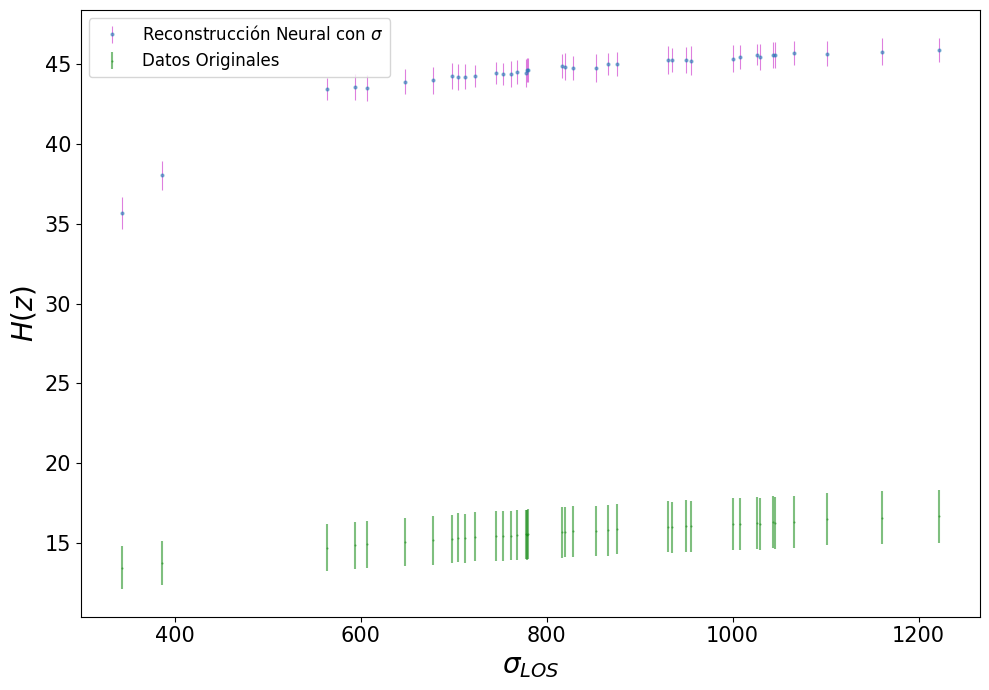

In [47]:
# Preparar los datos de entrada
X_sigma = df_data[['σLOS']].values
scaler_sigma = StandardScaler()
X_sigma_scaled = scaler_sigma.fit_transform(X_sigma)

# Realizar las predicciones usando σLOS
mc_dropout_num = 100  # Ejecutar Dropout 100 veces
predictions_sigma = np.zeros((mc_dropout_num, len(X_sigma), 2))

for j in range(mc_dropout_num):
    predictions_sigma[j] = model.predict(X_sigma_scaled)

# Obtener resultados promedio y varianza
prediction_mc_dropout_sigma = np.mean(predictions_sigma, axis=0)
std_mc_dropout_sigma = np.std(predictions_sigma, axis=0)

# Desescalar los resultados para Hz
hz_means_unscaled_sigma = scaler_Hz.inverse_transform(prediction_mc_dropout_sigma[:, 0].reshape(-1, 1))
hz_stds_unscaled_sigma = std_mc_dropout_sigma[:, 0] * scaler_Hz.scale_

# Graficar los resultados para Hz
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(X_sigma, hz_means_unscaled_sigma.flatten(), # Preparar los datos de entrada
X_temp = df_data[['T']].values  # Asegúrate de que el nombre de la columna sea correcto
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X_temp)

# Realizar las predicciones usando T
mc_dropout_num = 100  # Ejecutar Dropout 100 veces
predictions_temp = np.zeros((mc_dropout_num, len(X_temp), 2))

for j in range(mc_dropout_num):
    predictions_temp[j] = model.predict(X_temp_scaled)

# Obtener resultados promedio y varianza
prediction_mc_dropout_temp = np.mean(predictions_temp, axis=0)
std_mc_dropout_temp = np.std(predictions_temp, axis=0)

# Desescalar los resultados para S
s_means_unscaled_temp = scaler_S.inverse_transform(prediction_mc_dropout_temp[:, 1].reshape(-1, 1))
s_stds_unscaled_temp = std_mc_dropout_temp[:, 1] * scaler_S.scale_

# Graficar los resultados para S
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(X_temp, s_means_unscaled_temp.flatten(),
             yerr=s_stds_unscaled_temp.flatten(), markersize=2, fmt='o',
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.5,
             label='Reconstrucción Neural con $\sigma$')

# Graficar los valores originales de S
plt.errorbar(X_temp, y_S.flatten(), yerr=0.1 * y_S.flatten(),
             fmt='g.', markersize=1, alpha=0.5, label='Datos Originales')

plt.xlabel("T", fontsize=20)
plt.ylabel("$S$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.savefig('neural_rec_temp_S.png', dpi=100)
plt.show()

             yerr=hz_stds_unscaled_sigma.flatten(), markersize=2, fmt='o',
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.5,
             label='Reconstrucción Neural con $\sigma$')

# Graficar los valores originales de Hz
plt.errorbar(X_sigma, y_Hz.flatten(), yerr=0.1 * y_Hz.flatten(),
             fmt='g.', markersize=1, alpha=0.5, label='Datos Originales')

plt.xlabel("$\sigma_{LOS}$", fontsize=20)
plt.ylabel("$H(z)$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.savefig('neural_rec_sigma_Hz.png', dpi=100)
plt.show()


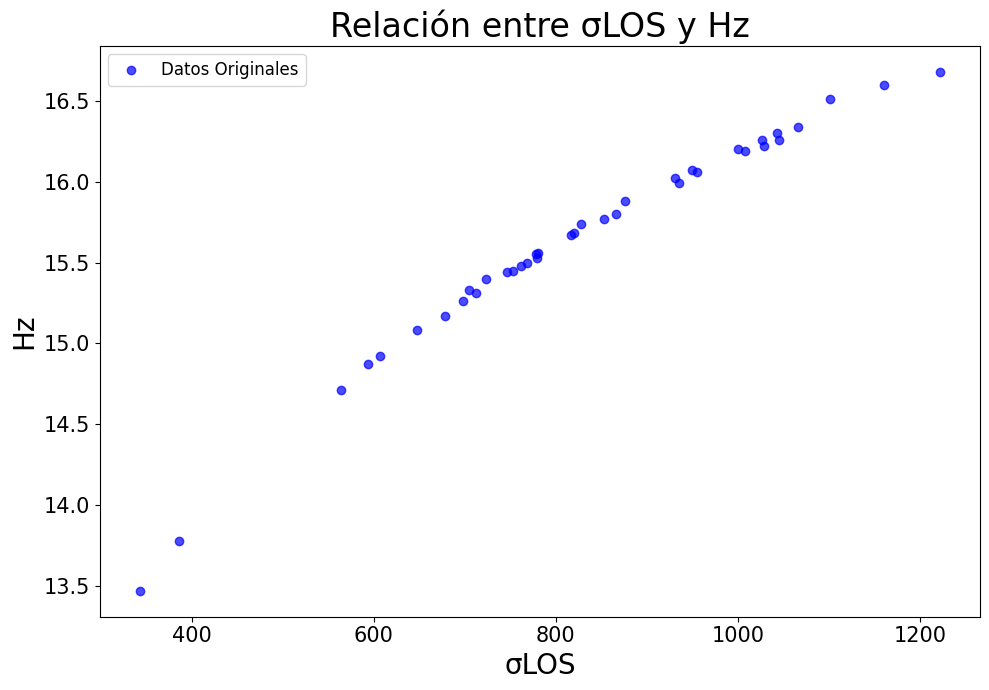

In [51]:
import matplotlib.pyplot as plt

# Supongamos que df_data tiene las columnas 'T' y 'S'
σLOS_values = df_data['σLOS'].values  # Valores de temperatura
Hz_values = df_data['Hz'].values  # Valores de S

# Crear la figura
plt.figure(figsize=(10, 7), dpi=100)

# Graficar T vs S
plt.scatter(σLOS_values, Hz_values, color='b', label='Datos Originales', alpha=0.7)

# Etiquetas y título
plt.xlabel("σLOS", fontsize=20)
plt.ylabel("Hz", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Relación entre σLOS y Hz", fontsize=24)
plt.legend(fontsize=12)

# Ajustar el diseño y guardar la figura
plt.tight_layout()
plt.savefig('σLOS_vs_Hz.png', dpi=100)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━

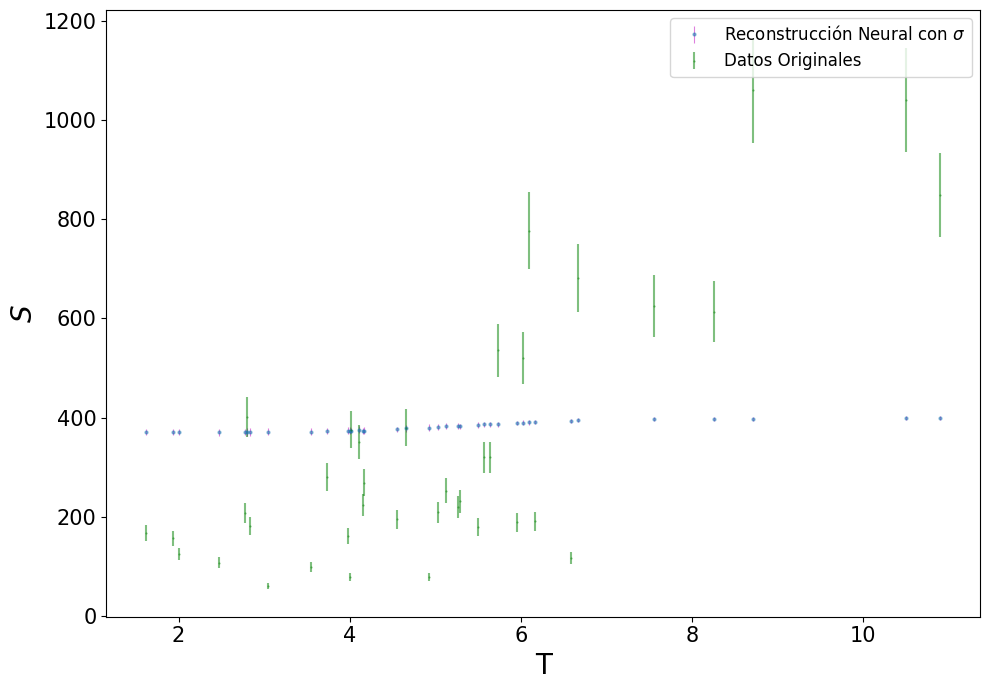

In [49]:
# Preparar los datos de entrada
X_temp = df_data[['Tx']].values  # Asegúrate de que el nombre de la columna sea correcto
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X_temp)

# Realizar las predicciones usando T
mc_dropout_num = 100  # Ejecutar Dropout 100 veces
predictions_temp = np.zeros((mc_dropout_num, len(X_temp), 2))

for j in range(mc_dropout_num):
    predictions_temp[j] = model.predict(X_temp_scaled)

# Obtener resultados promedio y varianza
prediction_mc_dropout_temp = np.mean(predictions_temp, axis=0)
std_mc_dropout_temp = np.std(predictions_temp, axis=0)

# Desescalar los resultados para S
s_means_unscaled_temp = scaler_S.inverse_transform(prediction_mc_dropout_temp[:, 1].reshape(-1, 1))
s_stds_unscaled_temp = std_mc_dropout_temp[:, 1] * scaler_S.scale_

# Graficar los resultados para S
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(X_temp, s_means_unscaled_temp.flatten(),
             yerr=s_stds_unscaled_temp.flatten(), markersize=2, fmt='o',
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.5,
             label='Reconstrucción Neural con $\sigma$')

# Graficar los valores originales de S
plt.errorbar(X_temp, y_S.flatten(), yerr=0.1 * y_S.flatten(),
             fmt='g.', markersize=1, alpha=0.5, label='Datos Originales')

plt.xlabel("T", fontsize=20)
plt.ylabel("$S$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.savefig('neural_rec_temp_S.png', dpi=100)
plt.show()


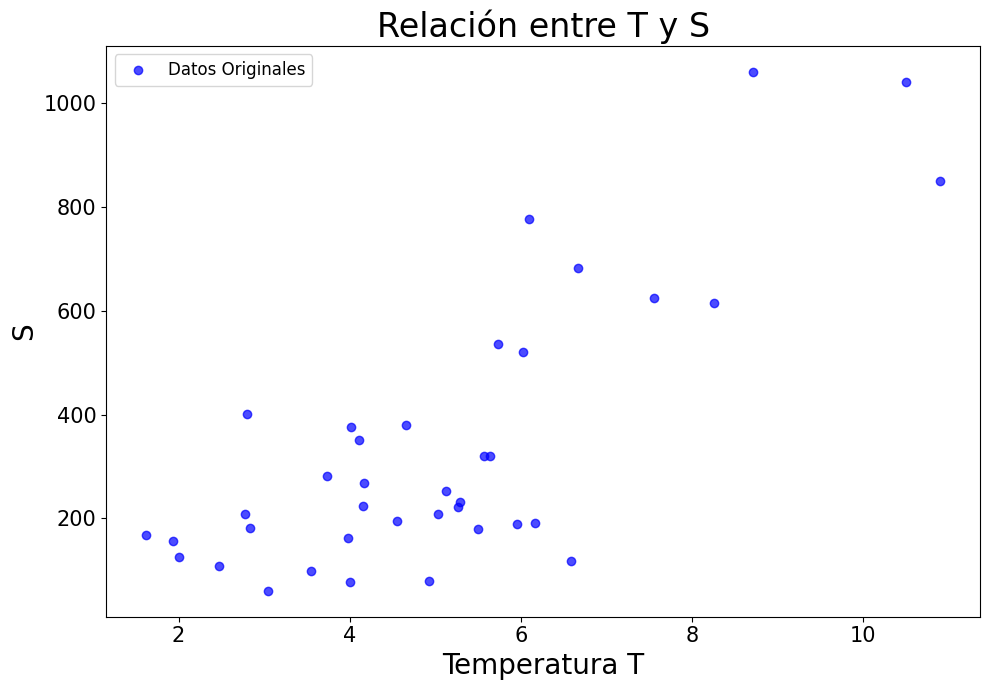

In [50]:
import matplotlib.pyplot as plt

# Supongamos que df_data tiene las columnas 'T' y 'S'
T_values = df_data['Tx'].values  # Valores de temperatura
S_values = df_data['S'].values  # Valores de S

# Crear la figura
plt.figure(figsize=(10, 7), dpi=100)

# Graficar T vs S
plt.scatter(T_values, S_values, color='b', label='Datos Originales', alpha=0.7)

# Etiquetas y título
plt.xlabel("Temperatura T", fontsize=20)
plt.ylabel("S", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Relación entre T y S", fontsize=24)
plt.legend(fontsize=12)

# Ajustar el diseño y guardar la figura
plt.tight_layout()
plt.savefig('T_vs_S.png', dpi=100)
plt.show()
